Why is this bad? Where is it good?

```bash
!pip install pandas
```

This usually invokes the host shell, which invokes installation in the host environment, which is not preferable (1) because of potential security concerns and (2) if you are using this notebook in a virtual environment.

Use a bang `!` before a shell command carefully, things like `!ls` and `!echo` are usually fine as they are just reading things. Certain commands might change certain things about your systems. If you're working in a notebook on the cloud (e.g. Binder, Google Colab, Oscar), sometimes it's not a big deal, but do watch out for certain commands that you copy and paste or inherit from somewhere else, as they might modify your data. 

So instead, do magic commands (see a list of magics [here](https://ipython.readthedocs.io/en/stable/interactive/magics.html):

```bash
%pip install pandas
```

**Preferably**, for reproducibility purposes, include what you need to install inside relevant environment files, e.g.:

- `requirements.txt`
- or `environment.yaml`

In [1]:
import numpy as np
# import pandas as pd  # this might not work if you use the bang ! instead of %
import matplotlib.pyplot as plt

## What could be done better ? 

In [2]:
T = 500
dt = 0.01

n_steps = int(np.ceil(T/dt))

t_vec, I_vec, V_vec = [], [], []
t = 0
I = 0
V = 0

t_vec.append(t)
I_vec.append(I)
V_vec.append(V)

V_spike = 4
tau = 15

dt = 0.1
for i in range(n_steps):
    t = t + dt
    
    t_off = 300
    if t >= 100 and t <= t_off:
        I = 3
    else:
        I = 0
        
    V_reset = -1       
    V_rest = 0
    V_thres = 1
    
    if V >= V_spike:
        V = V_reset
    elif V >= V_thres:
        V = V_spike # this step might be redundant    
    else:
        dV_dt = (-(V - V_rest) + I)/tau
        V = V + dt * dV_dt
    
    t_vec.append(t)
    I_vec.append(I)
    V_vec.append(V)
    

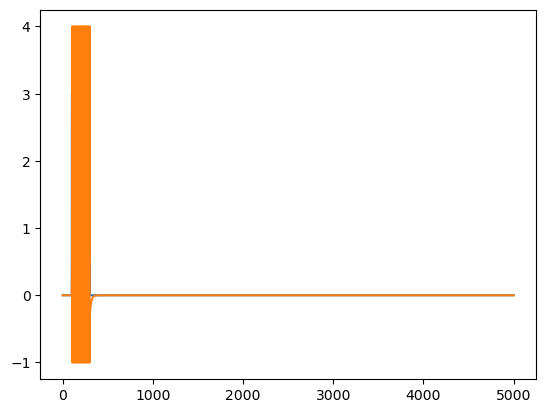

In [3]:
plt.plot(t_vec, I_vec)
plt.plot(t_vec, V_vec)

## Suggestions

**Goal**: simulate multiple times with different parameters

As discussed in the meeting:
- need comments for code
- `dt` is defined twice
- many (hyper)parameters of the model (`T`, `V_spike`, `tau`, `V_reset`, `V_rest`, `V_thres`) should be put at the top
- the code should be put into a function(s) with these parameters
- parameterize things that define inputs `I`:

```python
...
t_off = 300 # this one is a parameter
if t >= 100 and t <= t_off:
#       ^^^ can be redefined to `t_on`
    I = 3
#       ^^^ can be `I_max` or `I_on`
else:
    I = 0
#       ^^^ can be `I_off`
...
```
- parameterize initial conditions:

```python
I = 0
V = 0
```
- the parameters can then be combined into a `dict`
- the outputs can also be combined to a `dict` as well
- the outputs, if known, should be allocated 
- the plotting can be much better
    - axis labels
    - legends
    - ...
    

In [4]:
def _init_array(length, init_value, fill_value = np.nan):
    """Initialize an array"""
    v = np.full(length, fill_value=fill_value)
    v[0] = init_value
    return v

def LIF_sim(cfg: dict = dict()):
    """Leaky integrate & fire simulation
    Parameters
    ----------
    cfg: dict, default: empty dict()
        Configuration of simulation, containing parameters:
        
        Time parameters
        ---------------
        T: float, default: 100
            Max simulation time
        dt: float, default: 0.01
            Simulation time step
        
        Initial conditions
        ------------------
        I0: float, default: 0
            Initial input amplitude
        V0: float, default: 0
            Initial membrane potential
        
        Potential dynamics
        ------------------
        tau: float, default: 30
             Potential time constant
        V_spike: float, default: 4
            Spike amplitude
        V_thres: float, default: 1
            Threshold potential for spiking
        V_reset: float, default: -1
            Reset potential after spiking
        V_rest: float, default: 0
            Resting potential

        Input parameters
        ----------------
        t_on: float, default: 100
            Input on time
        t_off: float, default: 300
            Input off time
        I_on: float, default: 3
            Input on amplitude
        I_off: float, default: 0
            Input off amplitude
            
            
    Returns
    -------
    output: dict
        Output dictionary containing arrays:
        t: ndarray of float, length `n_steps = int(np.ceil(T/dt))`
            Time vector
        I: ndarray of float, same length as `t`
            Input amplitude vector
        V: ndarray of float, same length as `t`
            Membrane potential vector
            
    cfg: dict
        Simulation configurations/parameters.
        The returned `cfg` dictionary will be filled with default values
        of parameters that are not given in the input `cfg`
        
    """
    # 1. Obtain parameters
    # 1.1. Default config 
    def_cfg = dict(
        T = 500,
        dt = 0.01,
        I0 = 0,
        V0 = 0,
        tau = 30,
        V_spike = 4, 
        V_thres = 1, 
        V_reset = -1, 
        V_rest = 0,
        t_on = 100, 
        t_off = 300,
        I_on = 3,
        I_off = 0
    )
    
    # 1.2. Use default if not found
    def_cfg.update(cfg)
    cfg = def_cfg.copy()
    
    # 1.3. Obtain parameters
    T = cfg['T']
    dt = cfg['dt']
    I0 = cfg['I0']
    V0 = cfg['V0']
    tau = cfg['tau']
    V_spike = cfg['V_spike']
    V_thres = cfg['V_thres']
    V_reset = cfg['V_reset']
    V_rest = cfg['V_rest']
    t_on = cfg['t_on']
    t_off = cfg['t_off']
    I_on = cfg['I_on']
    I_off = cfg['I_off']
    
    # number of sim steps
    n_steps = int(np.ceil(T/dt))
    
    # 2. Initialize state variables 
    t = 0
    I = I0
    V = V0
    
    # 3. Output definition
    output = {
        't': _init_array(n_steps, t),
        'I': _init_array(n_steps, I0),
        'V': _init_array(n_steps, V0),
    }
    
    # 4. Simulate
    for i in range(1, n_steps):
        t = t + dt
        
        # Define input 
        if t >= t_on and t <= t_off:
            I = I_on
        else:
            I = I_off

        # Dynamics 
        if V >= V_spike:
            V = V_reset
        elif V >= V_thres:
            V = V_spike # this step might be redundant    
        else:
            dV_dt = (-(V - V_rest) + I)/tau
            V = V + dt * dV_dt
        
        # Save input 
        output['t'][i] = t
        output['I'][i] = I
        output['V'][i] = V
    
    return output, cfg

In [5]:
# Run some example simulations
cfg_1 = dict(
    V_thres = 1
)

cfg_2 = dict(
    V_thres = 2
)

cfg_3 = dict(
    V_thres = 1,
    tau = 100
)

output_1, cfg_1 = LIF_sim(cfg_1) 
output_2, cfg_2 = LIF_sim(cfg_2)
output_3, cfg_3 = LIF_sim(cfg_3)

In [6]:
def plot(output, cfg, display_keys=[]):
    """Helper for plotting"""
    plt.plot(output['t'], output['I'], c='k', label='Input (I)')
    plt.plot(output['t'], output['V'], c='b', label='Potential (V)')
    plt.xlabel('Time [no unit]')
    plt.ylabel('I or V [no unit]')
    
    title = []
    for k in display_keys:
        title.append(f'{k} = {cfg[k]}')
    title = ', '.join(title)
    plt.title(title)
    plt.legend(loc='lower left')
    plt.ylim([-3, 5])

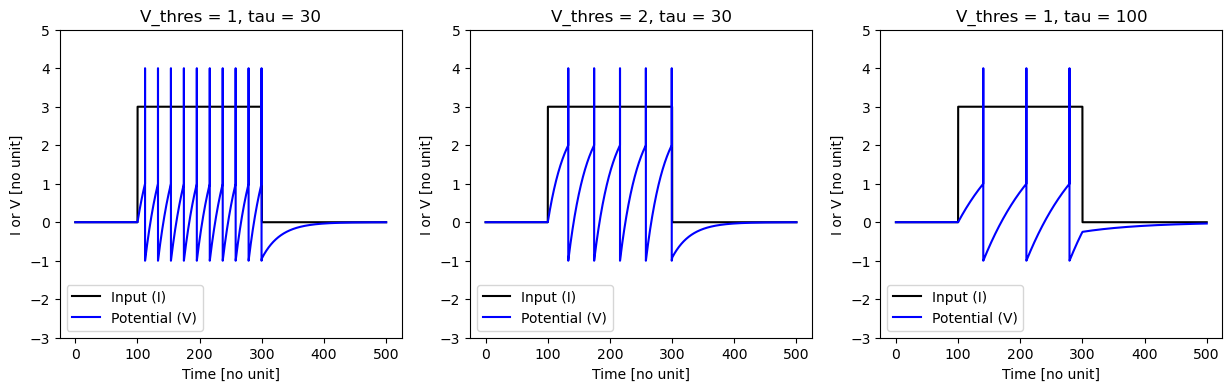

In [7]:
# Visualize results

display_keys = ['V_thres', 'tau']

plt.figure(figsize=(15,4))
plt.subplot(131)
plot(output_1, cfg_1, display_keys=display_keys)

plt.subplot(132)
plot(output_2, cfg_2, display_keys=display_keys)

plt.subplot(133)
plot(output_3, cfg_3, display_keys=display_keys)

plt.show()